In [1]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [49]:
from math import floor

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.stats import binom
import theano.tensor as tt
import seaborn as sns
import arviz
from numpy.random import default_rng

In [3]:
w = 6
N = 9

nIter = 1000
nChains = 4
nWarmup = 1000

In [53]:
obs = np.zeros(N)

rng = default_rng()
fill = rng.choice(N, size=w, replace=False)

obs[fill] = 1

In [66]:
with pm.Model() as model:
    theta = pm.Beta('theta', 1, 1) # same as the uniform distribution but conjugate
    globe = pm.Binomial('globe', N, theta, observed=w)
    trace = pm.sample(nIter, tune=nWarmup, return_inferencedata=True,
                     cores=4, chains=nChains, random_seed=1450154626)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [41]:
with pm.Model() as model:
    theta = pm.Uniform('theta', 0, 1)
    
    W = pm.Bernoulli('W', theta, shape=N, testval=np.random.binomial(1, 0.5, N))
    
    det = pm.Deterministic('det', tt.sum(W) / float(N))

    globe = pm.Binomial('globe', N, det, observed=w)
    
    step = pm.Metropolis(vars=[theta])
    trace = pm.sample(nIter, tune=nWarmup, step=step, 
                      return_inferencedata=True, cores=4,
                      random_seed=1450154626)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'theta_interval__': array(0.), 'W': array([1, 1, 1, 0, 1, 0, 0, 0, 1], dtype=int64)}

Initial evaluation results:
theta_interval__   -1.39
W                  -6.24
globe               -inf
Name: Log-probability of test_point, dtype: float64

In [61]:
with model:
    print(pm.summary(trace).round(2))

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.64  0.14    0.39     0.89        0.0      0.0    1835.0    2451.0   

       r_hat  
theta    1.0  


### Lecture 8

In [62]:
btrace4plot = trace['posterior']['theta'].data#[:, nWarmup:]
btrace4plot = btrace4plot.swapaxes(1, 0)

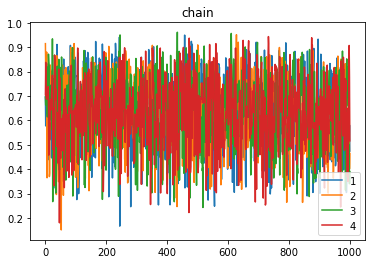

In [63]:
# traceplot as in the lecture
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(btrace4plot)
ax.legend([1, 2, 3, 4])
ax.set_title('chain')
plt.show()

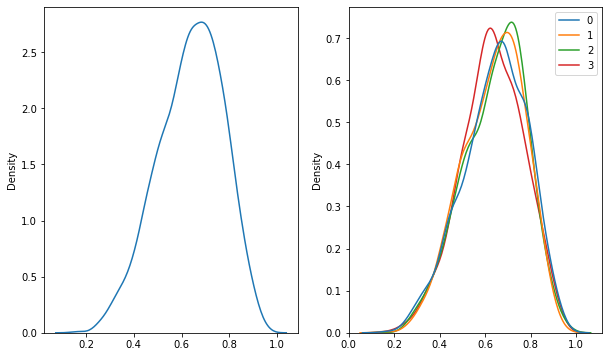

In [64]:
# diagnostics - density
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.kdeplot(data=btrace4plot.reshape(-1), ax=axes[0])
sns.kdeplot(data=btrace4plot, ax=axes[1])
plt.show()

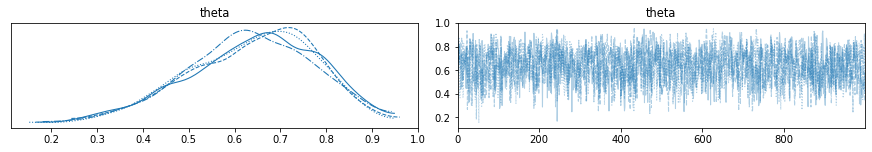

In [65]:
# ...or using `arviz.plot_trace` 
# note: this is without the warmup
arviz.plot_trace(trace['posterior'])
plt.show()